# **Time Series Forcasting**

In [100]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [101]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt
import ast
import warnings
warnings.filterwarnings("ignore")

In [102]:
dataset = pd.read_csv('/content/drive/MyDrive/Deep_learning/airline-price-prediction(raw_classification).csv')
dataset.head()

,date,airline,ch_code,num_code,dep_time,time_taken,stop,arr_time,type,route,TicketCategory
0,5/3/2022,Vistara,UK,812,9:45,10h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,business,"{'source': 'Bangalore', 'destination': 'Hydera...",very expensive
1,18-03-2022,Vistara,UK,975,5:45,06h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,12:15,business,"{'source': 'Delhi', 'destination': 'Hyderabad'}",very expensive
2,9/3/2022,GO FIRST,G8,7537,14:30,08h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:40,economy,"{'source': 'Mumbai', 'destination': 'Hyderabad'}",cheap
3,15-03-2022,GO FIRST,G8,287,10:40,09h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:20,economy,"{'source': 'Mumbai', 'destination': 'Delhi'}",moderate
4,22-03-2022,Vistara,UK,826,12:30,07h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,economy,"{'source': 'Chennai', 'destination': 'Kolkata'}",moderate


In [103]:
np.sum(dataset.duplicated())

941

In [104]:
dataset.shape

(240208, 11)

In [105]:
dataset = dataset.drop_duplicates(keep='first')

In [106]:
np.sum(dataset.duplicated())

0

In [107]:
dataset.shape

(239267, 11)

#Exploring the data types of the features

In [108]:
dataset.dtypes

date              object
airline           object
ch_code           object
num_code           int64
dep_time          object
time_taken        object
stop              object
arr_time          object
type              object
route             object
TicketCategory    object
dtype: object

In [109]:
np.sum(dataset.isna())

date              0
airline           0
ch_code           0
num_code          0
dep_time          0
time_taken        0
stop              0
arr_time          0
type              0
route             0
TicketCategory    0
dtype: int64

# These columns are one of 2 things :
1. Either a format fix of an original feature
2. A new feature I am going to extract from the data

In [110]:
dataset['full_information_timestamp'] = 0
dataset['flight_day'] = 0
dataset['flight_month'] = 0
dataset['week_day_of_flight'] = 0
dataset['departure_time_of_the_day']=0
dataset['arrival_time_of_the_day']=0
dataset['num_of_hours_taken'] =0
dataset['num_of_minutes_taken'] = 0
dataset['num_of_stops'] = 0
dataset['one_stop_in'] = 'Not Found'
dataset['source'] = 0
dataset['destination'] = 0
dataset['distance_between_2_cities'] = 0

# These columns are one of 2 things :
1. Either a format fix of an original feature
2. A new feature I am going to extract from the data

# **1.Date**

There were 2 ways to explain to python that date feature was of type datetime, one way was to convert it using pandas to datetime but unfortunately the month and the day were swapped in the new format as some observations were in the right format ( example : month is '02' ) and other observations were in the wrong format ( example : month is '2' ), so the other approach was to do it manually

In [111]:
def format_date(date):
    dashed_date = date.replace('/','-')
    return dashed_date

In [112]:
dataset['full_information_timestamp'] = dataset.date.apply(lambda date:format_date(date))

Extracting the day of the month and the month, and choosing a datetime format where the month is explicitly mentioned and there is no way for error in swapping the day with the month

In [113]:
def extract_day_month(date):
    splitted_date = date.split('-')
    day = int(splitted_date[0])
    month =int(splitted_date[1])
    if splitted_date[1]== '2' or splitted_date[1]== '02':
        new_date_format = 'February ' + splitted_date[0] + ', '+ splitted_date[2]
    else :
        new_date_format = 'March ' + splitted_date[0] + ', '+ splitted_date[2]
    return day,month,new_date_format

In [114]:
dataset[['flight_day', 'flight_month','full_information_timestamp']] = pd.DataFrame(dataset.full_information_timestamp.apply(lambda date: extract_day_month(date)).tolist(), index=dataset.index)

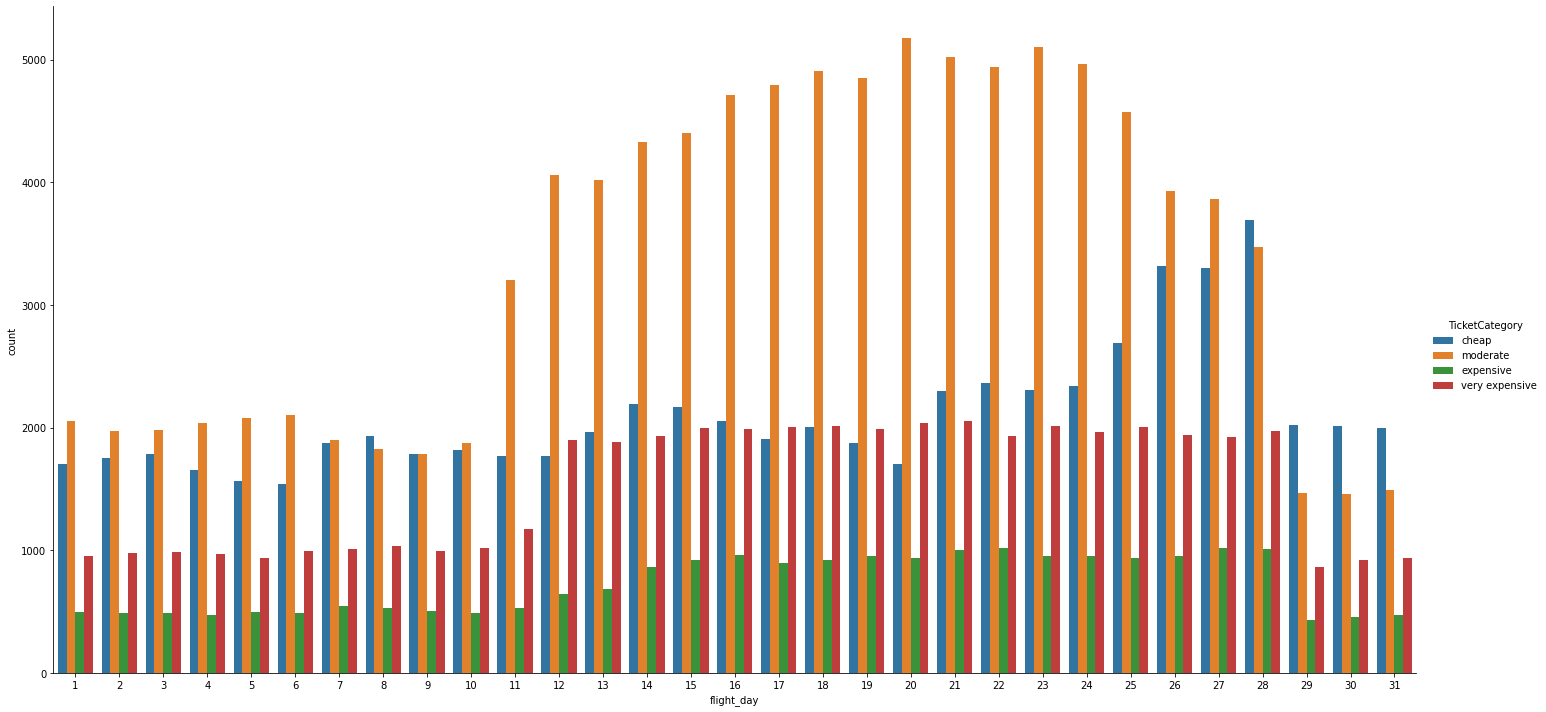

In [115]:
sns.catplot(data=dataset, x = 'flight_day',hue='TicketCategory',kind='count',height=10,aspect = 2,hue_order = ['cheap','moderate','expensive','very expensive'])

Pandas datetime has a lot of features that can be extracted easily from the date, like the day of the week which I believe is an important feature (some flights maybe cheaper/ more expensive on a specific day)

In [116]:
dataset['full_information_timestamp'] = pd.to_datetime(dataset['full_information_timestamp'])

In [117]:
def extract_weekday(day):
    return day.day_name()

In [118]:
dataset['week_day_of_flight'] = dataset.full_information_timestamp.apply(lambda date:extract_weekday(date))

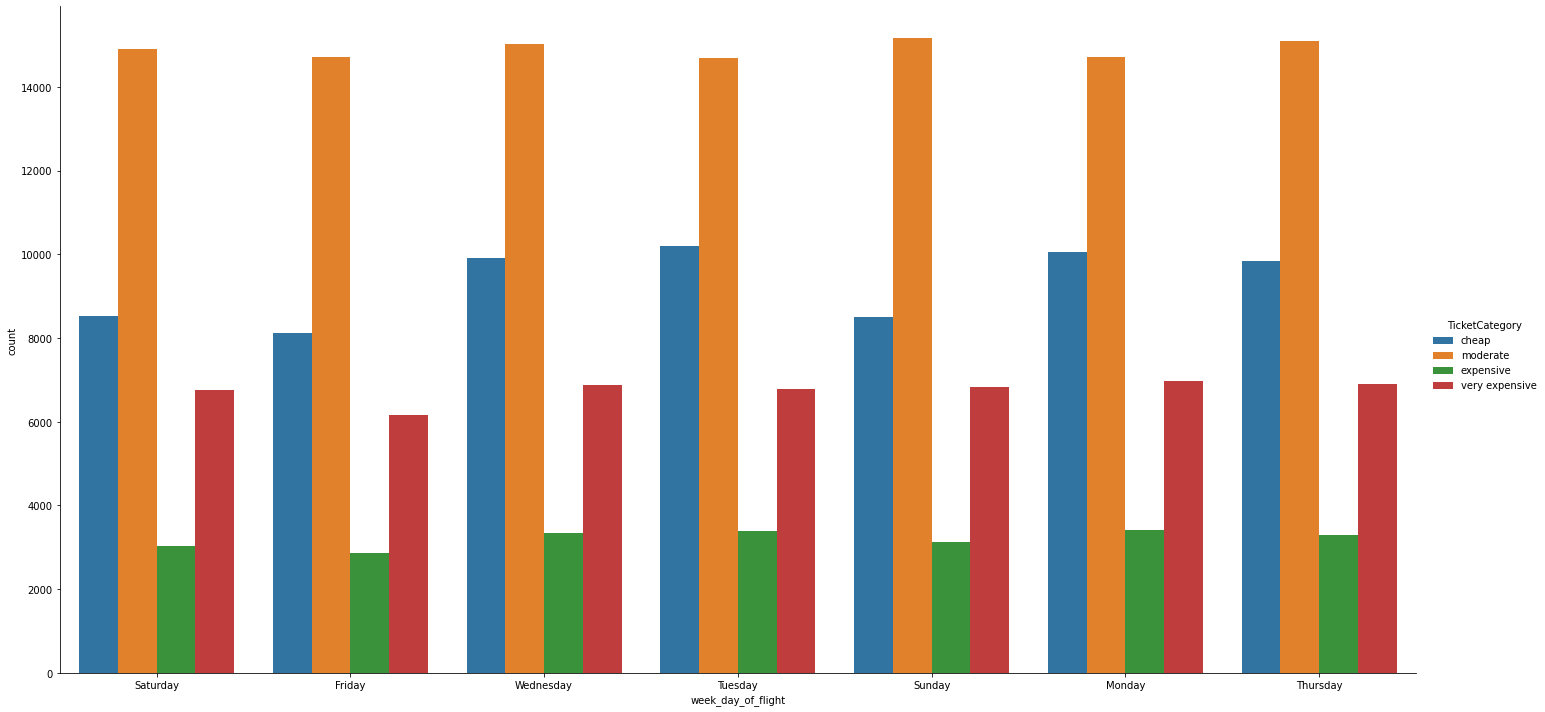

In [119]:
sns.catplot(data=dataset, x = 'week_day_of_flight',hue='TicketCategory',kind='count',height=10,aspect = 2,hue_order = ['cheap','moderate','expensive','very expensive'])

This feature is balanced

In [120]:
dataset['week_day_of_flight'].value_counts()

Wednesday    35171
Monday       35165
Thursday     35149
Tuesday      35052
Sunday       33636
Saturday     33239
Friday       31855
Name: week_day_of_flight, dtype: int64

# Since this is a time series data, data must be sorted according to the date, from older to newer, to prevent data leakage when splitting the data into a training and a testing set.
# Since there were many observations belonging to the same day, the data also had to be sorted according to the hour and minute of the time of flight departure

In [121]:
def embed_time_details_into_date(time,departure_time):
    hours_minutes = departure_time.split(':')
    full_information_timestamp = time.replace(hour=int(hours_minutes[0]),minute=int(hours_minutes[1]))
    return full_information_timestamp

In [122]:
dataset['full_information_timestamp']= dataset.apply(lambda dataFrame: embed_time_details_into_date(dataFrame['full_information_timestamp'], dataFrame['dep_time']),axis=1)

In [123]:
dataset.sort_values(by ='full_information_timestamp',inplace =True,kind = 'mergesort',ascending = True)

Observations start from the eleventh of Febrauary at 4:25 am, and end in the thirty first of March at 23:55 pm

In [124]:
dataset['full_information_timestamp']

6760     2022-02-11 04:25:00
167590   2022-02-11 04:25:00
5914     2022-02-11 04:45:00
94844    2022-02-11 04:45:00
96663    2022-02-11 04:45:00
                 ...        
132751   2022-03-31 23:55:00
133933   2022-03-31 23:55:00
154207   2022-03-31 23:55:00
154583   2022-03-31 23:55:00
183172   2022-03-31 23:55:00
Name: full_information_timestamp, Length: 239267, dtype: datetime64[ns]

In [125]:
dataset.head()

,date,airline,ch_code,num_code,dep_time,time_taken,stop,arr_time,type,route,...,week_day_of_flight,departure_time_of_the_day,arrival_time_of_the_day,num_of_hours_taken,num_of_minutes_taken,num_of_stops,one_stop_in,source,destination,distance_between_2_cities
6760,11/2/2022,AirAsia,I5,764,4:25,02h 10m,non-stop,6:35,economy,"{'source': 'Delhi', 'destination': 'Mumbai'}",...,Friday,0,0,0,0,0,Not Found,0,0,0
167590,11/2/2022,AirAsia,I5,764,4:25,10h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:45,economy,"{'source': 'Delhi', 'destination': 'Bangalore'}",...,Friday,0,0,0,0,0,Not Found,0,0,0
5914,11/2/2022,AirAsia,I5,548,4:45,11h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,16:15,economy,"{'source': 'Delhi', 'destination': 'Bangalore'}",...,Friday,0,0,0,0,0,Not Found,0,0,0
94844,11/2/2022,AirAsia,I5,548,4:45,07h 35m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,12:20,economy,"{'source': 'Delhi', 'destination': 'Bangalore'}",...,Friday,0,0,0,0,0,Not Found,0,0,0
96663,11/2/2022,AirAsia,I5,548,4:45,14h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:05,economy,"{'source': 'Delhi', 'destination': 'Bangalore'}",...,Friday,0,0,0,0,0,Not Found,0,0,0


# **2. Airline**

#There are two types of a class imbalace
1. Label imbalance -> where one label is dominating 
2. Feature imbalance -> where a class in a specific feature is the one that appears the most

To avoid feature imbalance we can calculate the percentage of the classes in each feature and those features of low frequencies in the observations can all be put in an "Others" class

In [126]:
def get_feature_percentage(feature):
    size = dataset.shape[0]
    ctr = 0
    for index in dataset[feature].value_counts().index:
        percentage = (int(dataset.airline.value_counts()[ctr])/size)*100
        print("{index} represents '{percentage}' of the data".format(index = index,percentage =percentage))
        ctr += 1

In [127]:
get_feature_percentage('airline')

Vistara represents '42.42749731471536' of the data
Air India represents '26.948973322689714' of the data
Indigo represents '14.448712108230556' of the data
GO FIRST represents '7.7808473379112035' of the data
AirAsia represents '5.3429850334563485' of the data
SpiceJet represents '3.015877659685623' of the data
StarAir represents '0.020061270463540733' of the data
Trujet represents '0.01504595284765555' of the data


Airlines Vistara, Air India, and Indigo form 82% of the feature, so we can safely put all other airlines in the other class

In [128]:
high_frequency_airlines =['Vistara','Air India','Indigo']
def remove_low_frequency_airlines():
    dataset ['airline'] = [airline if airline in high_frequency_airlines else 'Other_airline' for airline in dataset['airline']]
   

In [129]:
remove_low_frequency_airlines()

In [130]:
get_feature_percentage('airline')

Vistara represents '42.42749731471536' of the data
Air India represents '26.948973322689714' of the data
Other_airline represents '16.17481725436437' of the data
Indigo represents '14.448712108230556' of the data


Airline Indigo and Other_airline do not have any tickets classified as expensive or very expensive, this feature can be used as root in a classifying tree as if the airline is either Indigo or Other_airline, all the labels will be either cheap or moderate, so here I am putting airline Indigo in the others class

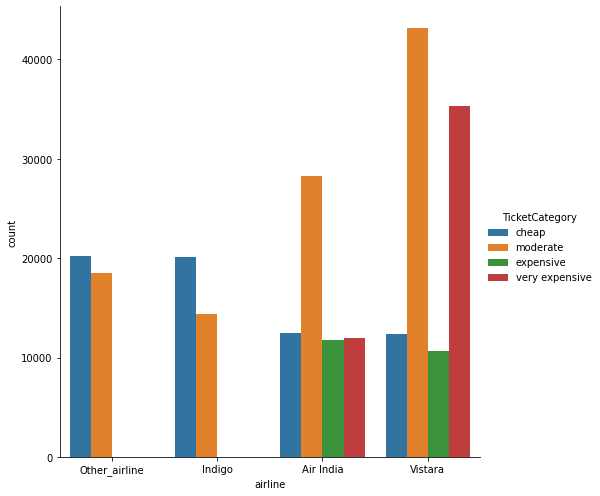

In [131]:
sns.catplot(data=dataset, x = 'airline',hue='TicketCategory',kind='count',height=7,aspect = 1,hue_order = ['cheap','moderate','expensive','very expensive'])

In [132]:
dataset['airline']= ['Other_airline' if airline == 'Indigo' else airline for airline in dataset['airline']]

In [133]:
dataset['airline'].value_counts()

Vistara          101515
Other_airline     73272
Air India         64480
Name: airline, dtype: int64

# **3.Ch_code**

There is a 100% dependancy between ch_code and the airline, as the ch_code is a code for the airline, so using both would cause redundancy while training, so this feature will be dropped

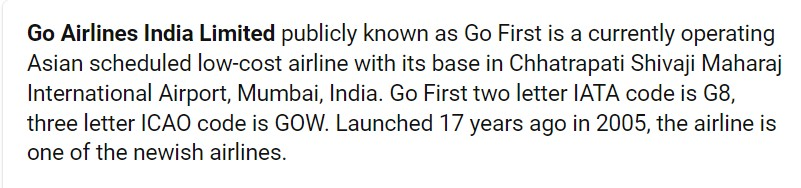

In [134]:
dataset.airline.value_counts()

Vistara          101515
Other_airline     73272
Air India         64480
Name: airline, dtype: int64

In [135]:
dataset.ch_code.value_counts()

UK    101515
AI     64480
6E     34571
G8     18617
I5     12784
SG      7216
S5        48
2T        36
Name: ch_code, dtype: int64

# **5. Departure time**
# **6. Time taken**
# **8. Arrival time**

The time taken is specified by the number of hours and the number of miutes,
some corner cases might be that there are no minutes (ex : 7 h) and another corner case is that the hour and minutes are represented in the hours (ex : 1.4 h )

In [136]:
def calculate_time_taken(time_taken):
    time = time_taken.split(' ')
    float_hour = time[0].split('.')
    hours = 0
    minutes = 0
    if(len(float_hour)>1):
        time[0] = float_hour[0] + 'h'
        time[1]= float_hour[1][:-1] + time[1]
    hours = int(time[0][:-1])
    if time[1][:-1] != '' : 
        minutes = ((int(time[1][:-1]))/100)*60
    else :
        minutes = 0
    return hours, minutes

In [137]:
dataset[['num_of_hours_taken', 'num_of_minutes_taken']] = pd.DataFrame(dataset.time_taken.apply(lambda time_taken: calculate_time_taken(time_taken)).tolist(), index=dataset.index)

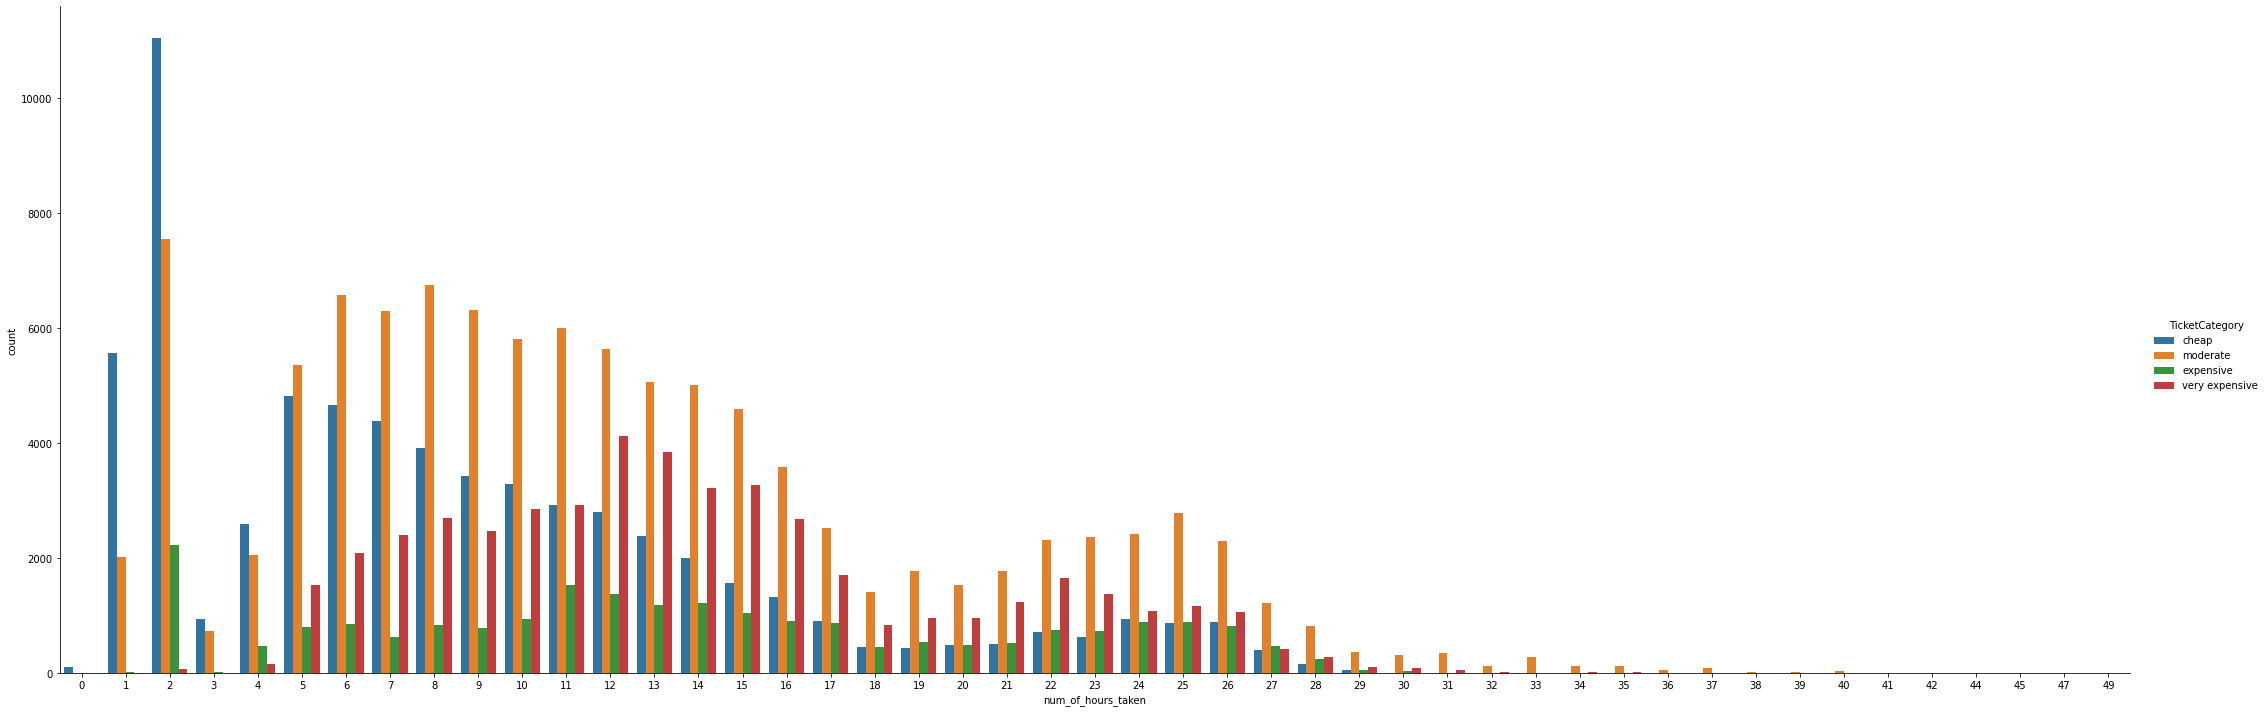

In [138]:
sns.catplot(data=dataset, x = 'num_of_hours_taken',hue='TicketCategory',kind='count',height=10,aspect = 3,hue_order = ['cheap','moderate','expensive','very expensive'])

In [139]:
def extract_hour(time):
    hour_minute = time.split(':')
    return int(hour_minute[0])

In [140]:
dataset['dep_time']= dataset.dep_time.apply(lambda time: extract_hour(time))

In [141]:
dataset['arr_time']= dataset.arr_time.apply(lambda time: extract_hour(time))

There is a 100% dependency between arrival time, departure time and time taken, and this dependency can be expressed by : time taken = arrival time - departure time.

Since using the hours themselves in arrival time and departure time will cause redundancy during training, we can extract the time of the day the flight departed and arrived as some times maybe cheaper or more expensive.

We dont know if there is a relation between the hour itself and the ticket category, so we will keep features (dep_time & arr_time) till we select our features

In [142]:
def categorize_time(hour):
    if hour <6:
        return 'Early morning'
    elif 6<= hour < 12 :
        return 'Morning'
    elif 12<= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

In [143]:
dataset['departure_time_of_the_day'] = dataset.dep_time.apply(lambda hour: categorize_time(hour))

In [144]:
dataset['arrival_time_of_the_day'] = dataset.arr_time.apply(lambda hour: categorize_time(hour))

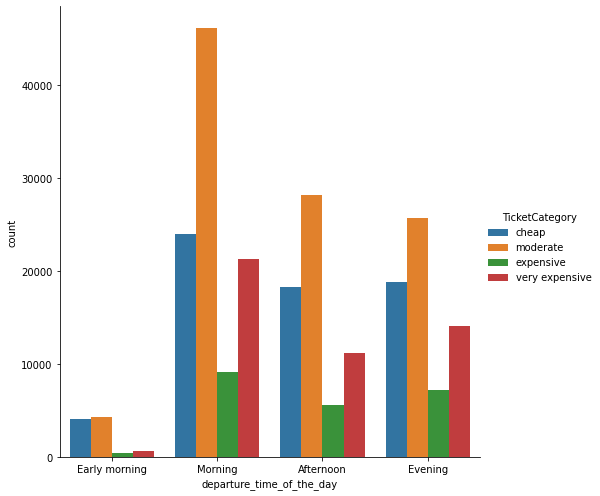

In [145]:
sns.catplot(data=dataset, x = 'departure_time_of_the_day',hue='TicketCategory',kind='count',height=7,aspect = 1,hue_order = ['cheap','moderate','expensive','very expensive'])

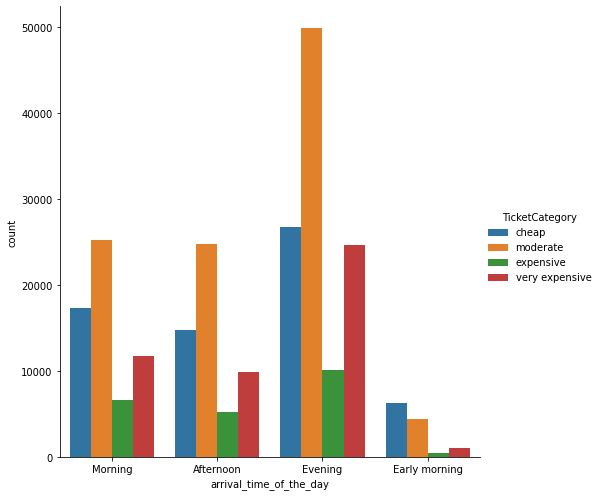

In [146]:
sns.catplot(data=dataset, x = 'arrival_time_of_the_day',hue='TicketCategory',kind='count',height=7,aspect = 1,hue_order = ['cheap','moderate','expensive','very expensive'])

# **7. Stop**

In [147]:
dataset.stop.value_counts()

1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t                      194141
non-stop                                                                         28944
2+-stop                                                                          10358
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU\n\t\t\t\t\t\t\t\t\t\t\t\t                 1485
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IDR\n\t\t\t\t\t\t\t\t\t\t\t\t                 1089
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Patna\n\t\t\t\t\t\t\t\t\t\t\t\t                558
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Indore\n\t\t\t\t\t\t\t\t\t\t\t\t               299
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia PAT\n\t\t\t\t\t\t\t\t\t\t\t\t                  273
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia MYQ\n\t\t\t\t\t\t\t\t\t\t\t\t                  267
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Bhubaneswar\n\t\t\t\t\t\t\t\t\t\t\t\t          248
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia KLH\n\t\t\t\t\t\t\t\t\t\t\t\t                  231
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia JGB\n\t

In [148]:
def split_num_of_stops(stop):
    if stop[:8] == 'non-stop':
        stop_count = 0
    elif stop[:6] == '1-stop':
        stop_count = 1
    else:
        stop_count = 2
    return stop_count

In [149]:
dataset['num_of_stops']= dataset.stop.apply(lambda stop:split_num_of_stops(stop))

In [150]:
def find_where_is_the_stop(stop):
    if stop[:6] == '1-stop':
        splitted = stop.split(' ')
        if len(splitted)>1:
            fine_splitting = splitted[1].split('\n')
            return fine_splitting[0]

In [151]:
dataset['one_stop_in']=dataset.stop.apply(lambda stop:find_where_is_the_stop(stop))

In [152]:
dataset.one_stop_in.value_counts()

IXU               1485
IDR               1089
Patna              558
Indore             299
PAT                273
MYQ                267
Bhubaneswar        248
KLH                231
JGB                149
JRG                134
STV                129
Delhi              123
BBI                119
Hyderabad          107
IXE                 91
Ranchi              86
Raipur              78
Chennai             64
Guwahati            46
Mangalore           35
Mysore              33
Mumbai              27
VTZ                 22
Nagpur              21
Kolkata             18
NDC                 17
RPR                 16
Lucknow             11
Surat               11
GOP                 10
Vishakhapatnam       7
NAG                  7
Kolhapur             4
GAU                  3
IXR                  3
GAY                  2
HYD                  1
Name: one_stop_in, dtype: int64

Most of the observations either the stop is not mentioned, or there wasn't a stop, the highest frequency is the 'Not Found', so it is safe to put all other stops in a class which represents that the stop is 'Found'

In [153]:
dataset['one_stop_in'] = [0 if stop == 'Not found' else 1 for stop in dataset ['one_stop_in']]

# **9. Type**

We chose 1 to represent business class as it will always be more exprensive that the economy class, so the model could train a large weight for it only used in business

In [154]:
dataset['type'] = [1 if kind_of_trip == 'business' else 0 for kind_of_trip in dataset['type']]

Type will also make a good root in a classifying tree as if the type was economy, it is not possible to find an expensive or a very expensive ticket

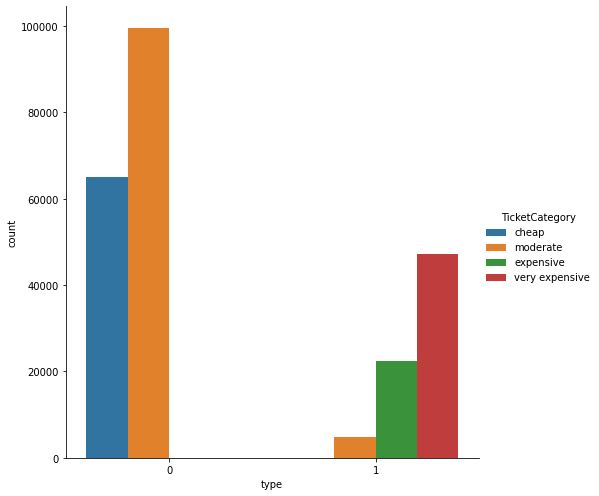

In [155]:
sns.catplot(data=dataset, x = 'type',hue='TicketCategory',kind='count',height=7,aspect = 1,hue_order = ['cheap','moderate','expensive','very expensive'])

# **10. Route**

Here I am using the abstract syntax tree library to change the strings in route feature to a dictionary so that accessing the source and destination would be easy

In [156]:
def split_route(route):
    path = ast.literal_eval(route)
    source = path['source']
    destination = path['destination']
    return source,destination

In [157]:
dataset[['source', 'destination']] = pd.DataFrame(dataset.route.apply(lambda route: split_route(route)).tolist(), index=dataset.index)

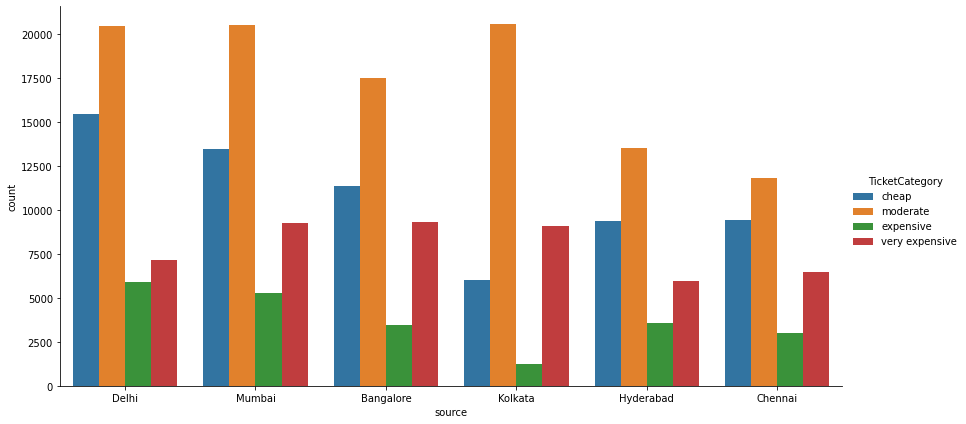

In [158]:
sns.catplot(data=dataset, x = 'source',hue='TicketCategory',kind='count',height=6,aspect = 2,hue_order = ['cheap','moderate','expensive','very expensive'])

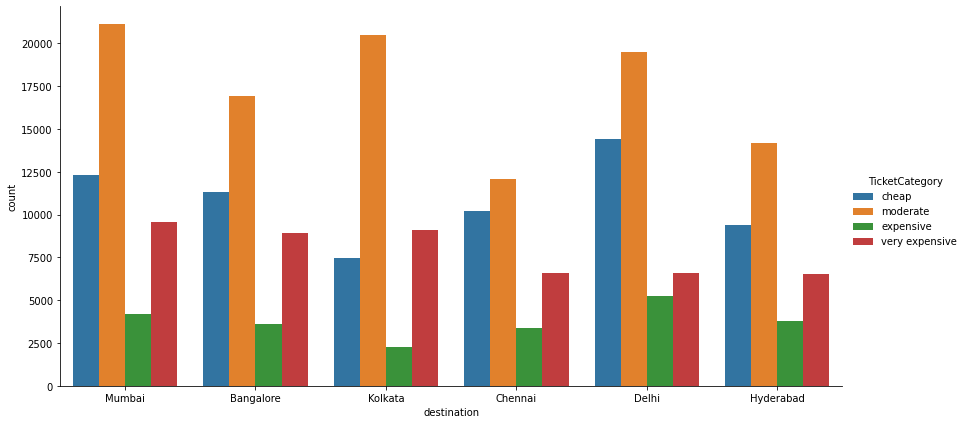

In [159]:
sns.catplot(data=dataset, x = 'destination',hue='TicketCategory',kind='count',height=6,aspect = 2,hue_order = ['cheap','moderate','expensive','very expensive'])

The distance between the 2 countries might be and important feature

(yes I searched for the distance between all of them :) , also the distance is in kilometers)

In [160]:
distances = dict()
distances['Mumbai','Kolkata'] = 2167
distances['Mumbai','Hyderabad'] = 721
distances['Mumbai','Chennai'] = 1344
distances['Mumbai','Bangalore'] = 995
distances['Mumbai','Delhi'] = 1439
distances['Delhi','Bangalore'] = 2169
distances['Delhi','Kolkata'] = 1554
distances['Delhi','Hyderabad'] = 1579
distances['Delhi','Chennai'] = 2202
distances['Bangalore','Kolkata']= 1560
distances['Bangalore','Hyderabad'] = 569
distances['Bangalore','Chennai'] = 348
distances['Kolkata','Hyderabad'] = 1489
distances['Kolkata','Chennai'] = 1663
distances['Hyderabad','Chennai'] = 628

In [161]:
def calculate_distance(source,destination):
    try :
        dist = distances[source,destination]
    except :
        dist = distances[destination,source]
    return dist

In [162]:
dataset['distance_between_2_cities'] = dataset.apply(lambda dataFrame: calculate_distance(dataFrame['source'], dataFrame['destination']), axis=1)
dataset['distance_between_2_cities'] = dataset['distance_between_2_cities']/dataset['distance_between_2_cities'].max()

Distance 0.708 has almost no expensive tickets

Distance 0.755 has no expensive tickets

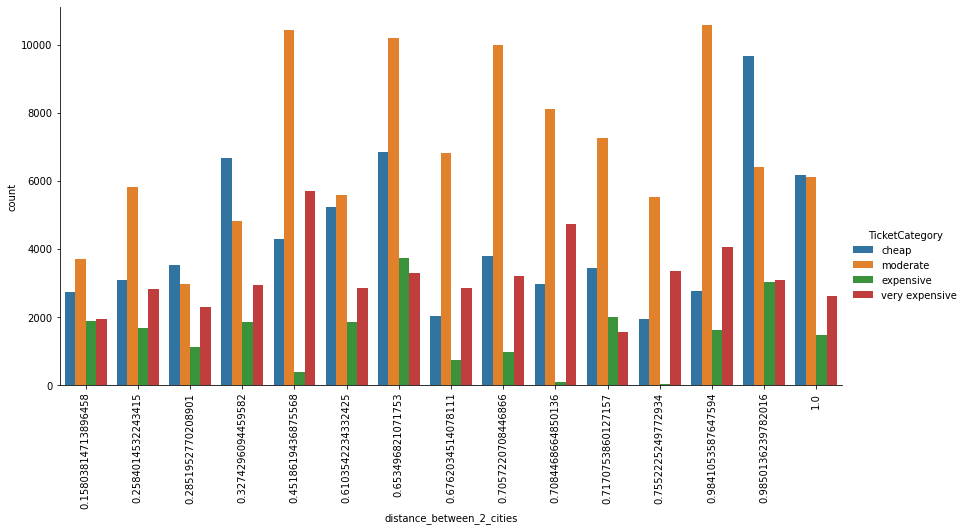

In [163]:
distanceVsCategory = sns.catplot(data=dataset, x = 'distance_between_2_cities',hue='TicketCategory',kind='count',height=6,aspect = 2,hue_order = ['cheap','moderate','expensive','very expensive'])
distanceVsCategory.set_xticklabels(rotation=90)

These features are balanced

In [164]:
dataset['source'].value_counts()

Delhi        49046
Mumbai       48507
Bangalore    41701
Kolkata      36898
Hyderabad    32451
Chennai      30664
Name: source, dtype: int64

In [165]:
dataset['destination'].value_counts()

Mumbai       47197
Delhi        45796
Bangalore    40840
Kolkata      39312
Hyderabad    33846
Chennai      32276
Name: destination, dtype: int64

In [166]:
dataset.head()

,date,airline,ch_code,num_code,dep_time,time_taken,stop,arr_time,type,route,...,week_day_of_flight,departure_time_of_the_day,arrival_time_of_the_day,num_of_hours_taken,num_of_minutes_taken,num_of_stops,one_stop_in,source,destination,distance_between_2_cities
6760,11/2/2022,Other_airline,I5,764,4,02h 10m,non-stop,6,0,"{'source': 'Delhi', 'destination': 'Mumbai'}",...,Friday,Early morning,Morning,2,6.0,0,1,Delhi,Mumbai,0.653497
167590,11/2/2022,Other_airline,I5,764,4,10h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14,0,"{'source': 'Delhi', 'destination': 'Bangalore'}",...,Friday,Early morning,Afternoon,10,12.0,1,1,Delhi,Bangalore,0.985014
5914,11/2/2022,Other_airline,I5,548,4,11h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,16,0,"{'source': 'Delhi', 'destination': 'Bangalore'}",...,Friday,Early morning,Afternoon,11,18.0,1,1,Delhi,Bangalore,0.985014
94844,11/2/2022,Other_airline,I5,548,4,07h 35m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,12,0,"{'source': 'Delhi', 'destination': 'Bangalore'}",...,Friday,Early morning,Afternoon,7,21.0,1,1,Delhi,Bangalore,0.985014
96663,11/2/2022,Other_airline,I5,548,4,14h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19,0,"{'source': 'Delhi', 'destination': 'Bangalore'}",...,Friday,Early morning,Evening,14,12.0,1,1,Delhi,Bangalore,0.985014


# **11. TicketCategory**

There is label imbalance

In [167]:
dataset['TicketCategory'].value_counts()

moderate          104340
cheap              65142
very expensive     47301
expensive          22484
Name: TicketCategory, dtype: int64

In [168]:
def encode_ticket_category(category):
    if category == 'cheap':
        return 0
    elif category == 'moderate':
        return 1
    elif category == 'expensive':
        return 2
    else :
        return 3

In [169]:
dataset['TicketCategory'] = dataset.TicketCategory.apply(lambda category: encode_ticket_category(category))

In [170]:
dataset.drop(columns=['date','ch_code','route','time_taken','stop','full_information_timestamp'],axis=1,inplace=True)

In [171]:
dataset.head()

,airline,num_code,dep_time,arr_time,type,TicketCategory,flight_day,flight_month,week_day_of_flight,departure_time_of_the_day,arrival_time_of_the_day,num_of_hours_taken,num_of_minutes_taken,num_of_stops,one_stop_in,source,destination,distance_between_2_cities
6760,Other_airline,764,4,6,0,1,11,2,Friday,Early morning,Morning,2,6.0,0,1,Delhi,Mumbai,0.653497
167590,Other_airline,764,4,14,0,1,11,2,Friday,Early morning,Afternoon,10,12.0,1,1,Delhi,Bangalore,0.985014
5914,Other_airline,548,4,16,0,1,11,2,Friday,Early morning,Afternoon,11,18.0,1,1,Delhi,Bangalore,0.985014
94844,Other_airline,548,4,12,0,1,11,2,Friday,Early morning,Afternoon,7,21.0,1,1,Delhi,Bangalore,0.985014
96663,Other_airline,548,4,19,0,1,11,2,Friday,Early morning,Evening,14,12.0,1,1,Delhi,Bangalore,0.985014


In [172]:
dataset.dtypes

airline                       object
num_code                       int64
dep_time                       int64
arr_time                       int64
type                           int64
TicketCategory                 int64
flight_day                     int64
flight_month                   int64
week_day_of_flight            object
departure_time_of_the_day     object
arrival_time_of_the_day       object
num_of_hours_taken             int64
num_of_minutes_taken         float64
num_of_stops                   int64
one_stop_in                    int64
source                        object
destination                   object
distance_between_2_cities    float64
dtype: object

In [173]:
dataset = pd.get_dummies(dataset,columns=['airline','source','destination','week_day_of_flight','departure_time_of_the_day','arrival_time_of_the_day'])

In [174]:
dataset.shape

(239267, 42)

In [175]:
for column in dataset.columns:
    if column != 'TicketCategory':
        corr,pvalue = stats.pearsonr(dataset[column],dataset['TicketCategory'])
        print("'{column}' has correlation of '{corr}' and pvalue of '{pval}'".format(column=column,corr=corr,pval=pvalue))

'num_code' has correlation of '-0.21338105685125094' and pvalue of '0.0'
'dep_time' has correlation of '0.01984506142962399' and pvalue of '2.7847314378790968e-22'
'arr_time' has correlation of '0.08848404913642748' and pvalue of '0.0'
'type' has correlation of '0.8641924907262843' and pvalue of '0.0'
'flight_day' has correlation of '-0.0008924922683469991' and pvalue of '0.6624306653933858'
'flight_month' has correlation of '-0.1447197673710081' and pvalue of '0.0'
'num_of_hours_taken' has correlation of '0.26215258999031693' and pvalue of '0.0'
'num_of_minutes_taken' has correlation of '-0.02336087268997781' and pvalue of '3.0142973417767415e-30'
'num_of_stops' has correlation of '0.18652236825253543' and pvalue of '0.0'
'one_stop_in' has correlation of 'nan' and pvalue of 'nan'
'distance_between_2_cities' has correlation of '-0.034530790525688464' and pvalue of '4.842590480417488e-64'
'airline_Air India' has correlation of '0.08310563742310129' and pvalue of '0.0'
'airline_Other_air

In [176]:
dataset.drop(columns=['one_stop_in'],axis=1,inplace=True)

In [177]:
for column in dataset.columns:
    if column != 'TicketCategory':
        corr,pvalue = stats.pearsonr(dataset[column],dataset['TicketCategory'])
        if (pvalue >=0.05):
            dataset.drop(columns=column, axis=1,inplace=True)

In [178]:
dataset.shape

(239267, 33)

Selected features are:

In [179]:
dataset.columns

Index(['num_code', 'dep_time', 'arr_time', 'type', 'TicketCategory',
       'flight_month', 'num_of_hours_taken', 'num_of_minutes_taken',
       'num_of_stops', 'distance_between_2_cities', 'airline_Air India',
       'airline_Other_airline', 'airline_Vistara', 'source_Bangalore',
       'source_Delhi', 'source_Hyderabad', 'source_Kolkata',
       'destination_Bangalore', 'destination_Chennai', 'destination_Delhi',
       'destination_Kolkata', 'destination_Mumbai',
       'week_day_of_flight_Saturday', 'week_day_of_flight_Sunday',
       'week_day_of_flight_Tuesday', 'week_day_of_flight_Wednesday',
       'departure_time_of_the_day_Afternoon',
       'departure_time_of_the_day_Early morning',
       'departure_time_of_the_day_Evening',
       'departure_time_of_the_day_Morning',
       'arrival_time_of_the_day_Afternoon',
       'arrival_time_of_the_day_Early morning',
       'arrival_time_of_the_day_Evening'],
      dtype='object')

In [180]:
dataset.head()

,num_code,dep_time,arr_time,type,TicketCategory,flight_month,num_of_hours_taken,num_of_minutes_taken,num_of_stops,distance_between_2_cities,...,week_day_of_flight_Sunday,week_day_of_flight_Tuesday,week_day_of_flight_Wednesday,departure_time_of_the_day_Afternoon,departure_time_of_the_day_Early morning,departure_time_of_the_day_Evening,departure_time_of_the_day_Morning,arrival_time_of_the_day_Afternoon,arrival_time_of_the_day_Early morning,arrival_time_of_the_day_Evening
6760,764,4,6,0,1,2,2,6.0,0,0.653497,...,0,0,0,0,1,0,0,0,0,0
167590,764,4,14,0,1,2,10,12.0,1,0.985014,...,0,0,0,0,1,0,0,1,0,0
5914,548,4,16,0,1,2,11,18.0,1,0.985014,...,0,0,0,0,1,0,0,1,0,0
94844,548,4,12,0,1,2,7,21.0,1,0.985014,...,0,0,0,0,1,0,0,1,0,0
96663,548,4,19,0,1,2,14,12.0,1,0.985014,...,0,0,0,0,1,0,0,0,0,1


In [181]:
dataset.to_csv("one_hot_encoded_dataset(classification).csv",index=False)